In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

# Vermont

## Load VEST File

In [2]:
vest_vt_20 = gp.read_file("./raw-from-source/VEST/vt_2020/vt_2020.shp")

<AxesSubplot:>

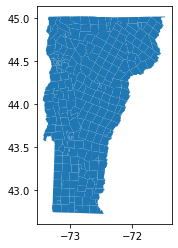

In [3]:
vest_vt_20.plot()

In [4]:
print(vest_vt_20)

    STATEFP20 COUNTYFP20                   NAME20  G20PREDBID  G20PRERTRU  \
0          50        001                  Whiting         124          84   
1          50        001                New Haven         732         396   
2          50        001                Salisbury         393         258   
3          50        001                   Orwell         367         351   
4          50        001              Ferrisburgh        1202         561   
..        ...        ...                      ...         ...         ...   
279        50        019         Troy - Orleans 2          98         115   
280        50        025            Westminster 4        1244         403   
281        50        025            Westminster 3          59          26   
282        50        025   Whitingham - Windham 6         372         319   
283        50        025  Whitingham - Bennington          25          21   

     G20PRELJOR  G20PREGHAW  G20PREIWES  G20PREOOTH  G20PREOSAN  ...  \
0  

## Election Results

### VEST Documentation

Election results from the Vermont Secretary of State (https://electionarchive.vermont.gov/)  


Vermont has four unorganized towns whose residents cast votes in neighboring towns. These were distributed back based on voting age population in the 2019 American Community Survey as 2020 Census results are not yet available at the township level. (Averill-Canaan, Buel's Gore-Huntington, Ferdinand-Brighton, Glastenbury-Shaftsbury.)

G20PREDBID - Joseph R. Biden (Democratic Party)
G20PRERTRU - Donald J. Trump (Republican Party)
G20PRELJOR - Jo Jorgensen (Libertarian Party)
G20PREGHAW - Howie Hawkins (Green Party)
G20PREIWES - Kanye West (Independent)
G20PREOOTH - Other Candidates on Ballot
G20PREOSAN - Bernie Sanders (Write-in)
G20PREOWRI - Other Write-in Candidates

G20HALDWEL - Peter Welch (Democratic Party)
G20HALDRBE - Miriam Berry (Republican Party)
G20HALCHEL - Christopher Helali (Communisty Party)
G20HALIBEC - Peter R. Becker (Independent)
G20HALIHOR - Marcia Horne (Independent)
G20HALIORR - Shawn Orr (Independent)
G20HALITRU - Jerry Trudell (Independent)
G20HALOWRI - Write-in Votes

G20GOVDZUC - David Zuckerman (Progressive Party and Democratic Party (fusion candidate))
G20GOVRSCO - Phil Scott (Republican Party)
G20GOVIHOY - Kevin Hoyt (Independent)
G20GOVTPEY - Emily Peyton (Truth Matters Pary)
G20GOVIWHI - Erynn Hazlett Whitney (Independent)
G20GOVIBIL - Wayne Billado III (Independent)
G20GOVIDEV - Michael Devost (Independent)
G20GOVUDIC - Charly Dickerson (Unaffiliated)
G20GOVOWRI - Write-in Votes

G20LTGDGRA - Molly Gray (Democratic Party)
G20LTGRMIL - Scott Milne (Republican Party)
G20LTGPERI - Cris Ericson (Progressive Party)
G20LTGIBIL - Wayne Billado III (Independent)
G20LTGBCOR - Ralph Corbo (Banigh the F-35s Party)
G20LTGOWRI - Write-in Votes

G20ATGDDON - T.J. Donovan (Democratic Party)
G20ATGRPAI - H. Brooke Paige (Republican Party)
G20ATGPERI - Cris Ericson (Progressive Party)
G20ATGOWRI - Write-in Votes

G20SOSDCON - Jim Condos (Democratic Party)
G20SOSRPAI - H. Brooke Paige (Republican Party)
G20SOSPERI - Cris Ericson (Progressive Party)
G20SOSISMI - Pamala Smith (Independent)
G20SOSOWRI - Write-in Votes

G20TREDPEA - Beth Pearce (Democratic Party)
G20TRERBRA - Barolyn Whitney Branagan (Republican Party)
G20TREPERI - Cris Ericson (Progressive Party)
G20TREIWRI - Alex Wright (Independent)
G20TREOWRI - Write-in Votes

G20AUDOHOF - Doug Hoffer (Democratic Party and Republican Party (fusion candidate))
G20AUDPERI - Cris Ericson (Progressive Party)
G20AUDOWRI - Write-in Votes

### Load Source Files

In [5]:
all_files = os.listdir("./raw-from-source/Election_Results/")
li = []
for file in all_files:
    if file  != ".DS_Store":
        ref = "./raw-from-source/Election_Results/"
        file_ref = ref+file
        file_prev = pd.read_csv(file_ref,engine='python',index_col=None)
        #Only keep the City/Town and Pct columns in one file, as they are duplicated
        #Delete unused columns in others
        if file != 'VT_Elections_Database__2020_Treasurer_General_Election_including_precincts.csv':
            file_prev = file_prev.drop(['City/Town', 'Ward', 'Pct','Blanks', 'Spoiled','Total Votes Cast'], axis=1)
            file_prev = file_prev.drop([0])
        else:
            file_prev = file_prev.drop(['Ward','Blanks', 'Spoiled','Total Votes Cast'], axis=1)
            file_prev = file_prev.drop([0])
        for col in file_prev.columns:
            file_prev.rename(columns={col:col+"-"+file[28:40]},inplace=True)
        li.append(file_prev)
    
#Define the dataframe, note we are add the loaded dataframes next to one another and not below
frame = pd.concat(li, axis=1, ignore_index=False)

### Clean up the election results

#### Rename and reorder the columns to match VEST

typo on 'Barolyn Whitney Branagan'

In [6]:
print(frame.columns)

Index(['City/Town-Treasurer_Ge', 'Pct-Treasurer_Ge',
       'Beth Pearce-Treasurer_Ge', 'Carolyn Whitney Branagan-Treasurer_Ge',
       'Alex Wright-Treasurer_Ge', 'Cris Ericson-Treasurer_Ge',
       'Write-Ins-Treasurer_Ge', 'T.J. Donovan-Attorney_Gen',
       'H. Brooke Paige-Attorney_Gen', 'Cris Ericson-Attorney_Gen',
       'Write-Ins-Attorney_Gen', 'Doug Hoffer-Auditor_Gene',
       'Cris Ericson-Auditor_Gene', 'Write-Ins-Auditor_Gene',
       'Molly Gray-Lieutenant_G', 'Scott Milne-Lieutenant_G',
       'Cris Ericson-Lieutenant_G', 'Wayne Billado, III-Lieutenant_G',
       'Ralph Corbo-Lieutenant_G', 'David Zuckerman-Lieutenant_G',
       'Write-Ins-Lieutenant_G', 'Phil Scott-Governor_Gen',
       'David Zuckerman-Governor_Gen', 'Kevin Hoyt-Governor_Gen',
       'Emily Peyton-Governor_Gen', 'Erynn Hazlett Whitney-Governor_Gen',
       'Wayne Billado, III-Governor_Gen', 'Michael A. Devost-Governor_Gen',
       'Charly Dickerson-Governor_Gen', 'Write-Ins-Governor_Gen',
       'Pete

In [7]:
temp_names = ['NAME20', 'NAME20_1',
"G20TREDPEA",
"G20TRERBRA",
"G20TREIWRI",
"G20TREPERI",
"G20TREOWRI",
"G20ATGDDON",
"G20ATGRPAI",
"G20ATGPERI",
"G20ATGOWRI",
"G20AUDOHOF",
"G20AUDPERI", 
"G20AUDOWRI",
"G20LTGDGRA",
"G20LTGRMIL",
"G20LTGPERI",
"G20LTGIBIL",
"G20LTGBCOR",
"G20LTGOWRI_to_add",
"G20LTGOWRI",
"G20GOVRSCO",
"G20GOVDZUC",
"G20GOVIHOY",
"G20GOVTPEY",
"G20GOVIWHI",
"G20GOVIBIL",
"G20GOVIDEV",
"G20GOVUDIC",
"G20GOVOWRI",
"G20HALDWEL",
"G20HALDRBE",
 "G20HALIBEC",
"G20HALIHOR",
"G20HALCHEL",
"G20HALIORR",
"G20HALITRU",
"G20HALOWRI",
"G20PREDBID",
"G20PRERTRU",
"G20PRELJOR",
"G20PREGHAW",
"G20PREIWES",
"G20PREOOTH_add_1",
 "G20PREOOTH_add_2",
"G20PREOSAN",
  "G20PREOOTH_add_3",
 "G20PREOOTH_add_4",
 "G20PREOOTH_add_5",
"G20PREOOTH_add_6",
 "G20PREOOTH_add_7",
 "G20PREOOTH_add_8",
"G20PREOOTH_add_9",
 "G20PREOOTH_add_10",
 "G20PREOOTH_add_11",
"G20PREOOTH_add_12",
 "G20PREOOTH_add_13",
 "G20PREOOTH_add_14",
"G20PREOOTH_add_15",
"G20PREOOTH_add_16",
"G20PREOWRI",
"G20SOSDCON",
"G20SOSRPAI",
"G20SOSISMI",
 "G20SOSPERI",
"G20SOSOWRI"]
    
frame.columns = temp_names

In [8]:
for race in temp_names:
    if race not in ['NAME20', 'NAME20_1']:
        frame[race]=frame[race].astype(str)
        frame[race]=frame[race].apply(lambda x: x.replace(',',''))
        frame[race]=frame[race].astype(float)
        frame[race]=frame[race].astype(int)

In [9]:
frame.columns

Index(['NAME20', 'NAME20_1', 'G20TREDPEA', 'G20TRERBRA', 'G20TREIWRI',
       'G20TREPERI', 'G20TREOWRI', 'G20ATGDDON', 'G20ATGRPAI', 'G20ATGPERI',
       'G20ATGOWRI', 'G20AUDOHOF', 'G20AUDPERI', 'G20AUDOWRI', 'G20LTGDGRA',
       'G20LTGRMIL', 'G20LTGPERI', 'G20LTGIBIL', 'G20LTGBCOR',
       'G20LTGOWRI_to_add', 'G20LTGOWRI', 'G20GOVRSCO', 'G20GOVDZUC',
       'G20GOVIHOY', 'G20GOVTPEY', 'G20GOVIWHI', 'G20GOVIBIL', 'G20GOVIDEV',
       'G20GOVUDIC', 'G20GOVOWRI', 'G20HALDWEL', 'G20HALDRBE', 'G20HALIBEC',
       'G20HALIHOR', 'G20HALCHEL', 'G20HALIORR', 'G20HALITRU', 'G20HALOWRI',
       'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW', 'G20PREIWES',
       'G20PREOOTH_add_1', 'G20PREOOTH_add_2', 'G20PREOSAN',
       'G20PREOOTH_add_3', 'G20PREOOTH_add_4', 'G20PREOOTH_add_5',
       'G20PREOOTH_add_6', 'G20PREOOTH_add_7', 'G20PREOOTH_add_8',
       'G20PREOOTH_add_9', 'G20PREOOTH_add_10', 'G20PREOOTH_add_11',
       'G20PREOOTH_add_12', 'G20PREOOTH_add_13', 'G20PREOOTH_add_14',


In [10]:
frame['G20PREOOTH']=0
frame["G20LTGOWRI"]+=frame["G20LTGOWRI_to_add"]
for val in range(1,17):
    name_string = 'G20PREOOTH_add_'+str(val)
    frame['G20PREOOTH']+=frame[name_string]

In [11]:
frame = frame[['NAME20', 'NAME20_1',
"G20TREDPEA",
"G20TRERBRA",
"G20TREIWRI",
"G20TREPERI",
"G20TREOWRI",
"G20ATGDDON",
"G20ATGRPAI",
"G20ATGPERI",
"G20ATGOWRI",
"G20AUDOHOF",
"G20AUDPERI", 
"G20AUDOWRI",
"G20LTGDGRA",
"G20LTGRMIL",
"G20LTGPERI",
"G20LTGIBIL",
"G20LTGBCOR",
"G20LTGOWRI_to_add",
"G20LTGOWRI",
"G20GOVRSCO",
"G20GOVDZUC",
"G20GOVIHOY",
"G20GOVTPEY",
"G20GOVIWHI",
"G20GOVIBIL",
"G20GOVIDEV",
"G20GOVUDIC",
"G20GOVOWRI",
"G20HALDWEL",
"G20HALDRBE",
 "G20HALIBEC",
"G20HALIHOR",
"G20HALCHEL",
"G20HALIORR",
"G20HALITRU",
"G20HALOWRI",
"G20PREDBID",
"G20PRERTRU",
"G20PRELJOR",
"G20PREGHAW",
"G20PREIWES",
"G20PREOOTH",
"G20PREOSAN",
"G20PREOWRI",
"G20SOSDCON",
"G20SOSRPAI",
"G20SOSISMI",
 "G20SOSPERI",
"G20SOSOWRI"]]

In [12]:
print(frame.columns)

Index(['NAME20', 'NAME20_1', 'G20TREDPEA', 'G20TRERBRA', 'G20TREIWRI',
       'G20TREPERI', 'G20TREOWRI', 'G20ATGDDON', 'G20ATGRPAI', 'G20ATGPERI',
       'G20ATGOWRI', 'G20AUDOHOF', 'G20AUDPERI', 'G20AUDOWRI', 'G20LTGDGRA',
       'G20LTGRMIL', 'G20LTGPERI', 'G20LTGIBIL', 'G20LTGBCOR',
       'G20LTGOWRI_to_add', 'G20LTGOWRI', 'G20GOVRSCO', 'G20GOVDZUC',
       'G20GOVIHOY', 'G20GOVTPEY', 'G20GOVIWHI', 'G20GOVIBIL', 'G20GOVIDEV',
       'G20GOVUDIC', 'G20GOVOWRI', 'G20HALDWEL', 'G20HALDRBE', 'G20HALIBEC',
       'G20HALIHOR', 'G20HALCHEL', 'G20HALIORR', 'G20HALITRU', 'G20HALOWRI',
       'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW', 'G20PREIWES',
       'G20PREOOTH', 'G20PREOSAN', 'G20PREOWRI', 'G20SOSDCON', 'G20SOSRPAI',
       'G20SOSISMI', 'G20SOSPERI', 'G20SOSOWRI'],
      dtype='object')


In [13]:
data_columns = ['G20PRELJOR', 'G20PREGHAW', 'G20PREIWES', 'G20PREOOTH', 'G20PREOSAN',
       'G20PREOWRI', 'G20HALDWEL', 'G20HALDRBE', 'G20HALCHEL', 'G20HALIBEC',
       'G20HALIHOR', 'G20HALIORR', 'G20HALITRU', 'G20HALOWRI', 'G20GOVDZUC',
       'G20GOVRSCO', 'G20GOVIHOY', 'G20GOVTPEY', 'G20GOVIWHI', 'G20GOVIBIL',
       'G20GOVIDEV', 'G20GOVUDIC', 'G20GOVOWRI', 'G20LTGDGRA', 'G20LTGRMIL',
       'G20LTGPERI', 'G20LTGIBIL', 'G20LTGBCOR', 'G20LTGOWRI', 'G20ATGDDON',
       'G20ATGRPAI', 'G20ATGPERI', 'G20ATGOWRI', 'G20SOSDCON', 'G20SOSRPAI',
       'G20SOSPERI', 'G20SOSISMI', 'G20SOSOWRI', 'G20TREDPEA', 'G20TRERBRA',
       'G20TREPERI', 'G20TREIWRI', 'G20TREOWRI', 'G20AUDOHOF', 'G20AUDPERI',
       'G20AUDOWRI']

In [14]:
print(vest_vt_20.columns)

Index(['STATEFP20', 'COUNTYFP20', 'NAME20', 'G20PREDBID', 'G20PRERTRU',
       'G20PRELJOR', 'G20PREGHAW', 'G20PREIWES', 'G20PREOOTH', 'G20PREOSAN',
       'G20PREOWRI', 'G20HALDWEL', 'G20HALDRBE', 'G20HALCHEL', 'G20HALIBEC',
       'G20HALIHOR', 'G20HALIORR', 'G20HALITRU', 'G20HALOWRI', 'G20GOVDZUC',
       'G20GOVRSCO', 'G20GOVIHOY', 'G20GOVTPEY', 'G20GOVIWHI', 'G20GOVIBIL',
       'G20GOVIDEV', 'G20GOVUDIC', 'G20GOVOWRI', 'G20LTGDGRA', 'G20LTGRMIL',
       'G20LTGPERI', 'G20LTGIBIL', 'G20LTGBCOR', 'G20LTGOWRI', 'G20ATGDDON',
       'G20ATGRPAI', 'G20ATGPERI', 'G20ATGOWRI', 'G20SOSDCON', 'G20SOSRPAI',
       'G20SOSPERI', 'G20SOSISMI', 'G20SOSOWRI', 'G20TREDPEA', 'G20TRERBRA',
       'G20TREPERI', 'G20TREIWRI', 'G20TREOWRI', 'G20AUDOHOF', 'G20AUDPERI',
       'G20AUDOWRI', 'geometry'],
      dtype='object')


#### Clean the column data types

#### Remove rows that count total votes

In [15]:
frame = frame[frame['NAME20']!="TOTALS"]

#### Compare race-wide election totals against VEST

In [16]:
frame

,NAME20,NAME20_1,G20TREDPEA,G20TRERBRA,G20TREIWRI,G20TREPERI,G20TREOWRI,G20ATGDDON,G20ATGRPAI,G20ATGPERI,...,G20PREGHAW,G20PREIWES,G20PREOOTH,G20PREOSAN,G20PREOWRI,G20SOSDCON,G20SOSRPAI,G20SOSISMI,G20SOSPERI,G20SOSOWRI
1,Addison,NaN,372,404,33,20,0,500,317,25,...,2,6,19,1,3,424,357,43,16,0
2,Albany,NaN,255,213,16,28,0,301,184,27,...,2,0,10,2,1,275,189,29,20,0
3,Alburgh,NaN,436,508,61,23,2,589,396,45,...,3,4,8,2,3,477,405,127,23,3
4,Andover,NaN,180,135,12,24,0,211,116,15,...,0,2,7,1,2,198,115,16,21,0
5,Arlington,NaN,739,492,75,62,2,853,465,63,...,3,3,15,1,2,792,464,91,51,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,Wolcott,NaN,501,277,53,31,1,578,261,43,...,2,6,14,1,2,527,278,55,23,0
272,Woodbury,NaN,336,178,16,29,0,364,172,26,...,3,0,8,2,0,352,182,16,19,0
273,Woodford,NaN,85,80,11,8,2,95,81,7,...,1,0,0,0,0,87,78,20,0,1
274,Woodstock,NaN,1293,485,80,80,0,1458,394,78,...,6,4,18,5,11,1365,422,112,64,3


In [17]:
print("Races with differences will be printed below:")
for race in data_columns:
    if (sum(vest_vt_20[race])-sum(frame[race]) != 0):
        print(race+" has a difference of "+str(sum(vest_vt_20[race])-sum(frame[race]))+" votes")
        print("\tVEST: "+str(sum(vest_vt_20[race]))+" votes")
        print("\tSOURCES: "+str(sum(frame[race]))+" votes")
print("")
print("All other races are equal")

Races with differences will be printed below:

All other races are equal


### Following VEST documentation, allocate votes to the four unorganized towns

#### Documentation

> Vermont has four unorganized towns whose residents cast votes in neighboring towns. These were distributed back based on voting age population in the 2019 American Community Survey as 2020 Census results are not yet available at the township level. (Averill-Canaan, Buel's Gore-Huntington, Ferdinand-Brighton, Glastenbury-Shaftsbury.)

#### Add empty precincts to the dataframe (will allocate votes afterwards)

In [18]:
new_df = pd.DataFrame([["Averill","",    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                       ["Buels Gore","", 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                       ["Ferdinand","",  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                       ["Glastenbury","",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
                      ,columns=frame.columns)
frame = frame.append(new_df)
frame.reset_index(inplace=True,drop=True)

#### Load the ACS data

In [19]:
acs_allocating_votes = pd.read_csv("./raw-from-source/ACS/ACSST5Y2019.S0101_2021-07-20T203240/ACSST5Y2019.S0101_data_with_overlays_2021-07-20T203200.csv")        

In [20]:
#Clean up the header
acs_allocating_votes.columns = acs_allocating_votes.iloc[0]
acs_allocating_votes = acs_allocating_votes.drop([0])

#Grab needed columns
acs_allocating_votes = acs_allocating_votes[["Geographic Area Name",'Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 years and over']]

#Rename columns
acs_allocating_votes.columns=["Place","VAP Estimate"]

#Clean columns
acs_allocating_votes["VAP Estimate"]=acs_allocating_votes["VAP Estimate"].astype(float)

#Define a "ratio" column, fill it below with the percentage of voters from the area where votes were counted
acs_allocating_votes["ratio"]=0

In [21]:
print(acs_allocating_votes)

                                          Place  VAP Estimate  ratio
1  Glastenbury town, Bennington County, Vermont           0.0      0
2   Shaftsbury town, Bennington County, Vermont        2590.0      0
3        Buels gore, Chittenden County, Vermont          17.0      0
4   Huntington town, Chittenden County, Vermont        1592.0      0
5           Averill town, Essex County, Vermont          10.0      0
6          Brighton town, Essex County, Vermont         986.0      0
7            Canaan town, Essex County, Vermont         718.0      0
8         Ferdinand town, Essex County, Vermont          21.0      0


In [22]:
#Glastenbury (from Shaftsbury)
acs_allocating_votes.iloc[0,2]=acs_allocating_votes.iloc[0,1]/acs_allocating_votes.iloc[1,1]
#Buels (from Huntington)
acs_allocating_votes.iloc[2,2]=acs_allocating_votes.iloc[2,1]/acs_allocating_votes.iloc[3,1]
#Averill (from Canaan)
acs_allocating_votes.iloc[4,2]=acs_allocating_votes.iloc[4,1]/acs_allocating_votes.iloc[6,1]
#Ferdinand (from Brighton)
acs_allocating_votes.iloc[7,2]=acs_allocating_votes.iloc[7,1]/acs_allocating_votes.iloc[5,1]

print(acs_allocating_votes)

                                          Place  VAP Estimate     ratio
1  Glastenbury town, Bennington County, Vermont           0.0  0.000000
2   Shaftsbury town, Bennington County, Vermont        2590.0  0.000000
3        Buels gore, Chittenden County, Vermont          17.0  0.010678
4   Huntington town, Chittenden County, Vermont        1592.0  0.000000
5           Averill town, Essex County, Vermont          10.0  0.013928
6          Brighton town, Essex County, Vermont         986.0  0.000000
7            Canaan town, Essex County, Vermont         718.0  0.000000
8         Ferdinand town, Essex County, Vermont          21.0  0.021298


#### Allocate votes to Averill from Canaan

In [23]:
for race in data_columns:
    frame.loc[frame["NAME20"]=="Averill",race] = round(frame.loc[frame["NAME20"]=="Canaan",race].values[0]*0.013928,0).astype(int)
    frame.loc[frame["NAME20"]=="Canaan",race]= round(frame.loc[frame["NAME20"]=="Canaan",race].values[0]*(1-0.013928),0).astype(int)
print(frame.loc[frame["NAME20"]=="Averill"])
print(frame.loc[frame["NAME20"]=="Canaan"])

      NAME20 NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  G20TREPERI  \
275  Averill                    3           3           1           0   

     G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  G20PREGHAW  \
275           0           4           2           1  ...           0   

     G20PREIWES  G20PREOOTH  G20PREOSAN  G20PREOWRI  G20SOSDCON  G20SOSRPAI  \
275           0           0           0           0           3           3   

     G20SOSISMI  G20SOSPERI  G20SOSOWRI  
275           1           0           0  

[1 rows x 51 columns]
    NAME20 NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  G20TREPERI  \
47  Canaan      NaN         192         203          54           7   

    G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  G20PREGHAW  \
47           1         251         169          36  ...           0   

    G20PREIWES  G20PREOOTH  G20PREOSAN  G20PREOWRI  G20SOSDCON  G20SOSRPAI  \
47           0           7           1           3         194         206   


#### Allocate votes to Buels Gore from Huntington

In [24]:
frame.loc[frame["NAME20"]=="Huntington"]

for race in data_columns:
    frame.loc[frame["NAME20"]=="Buels Gore",race] = round(frame.loc[frame["NAME20"]=="Huntington",race].values[0]*0.010678,0).astype(int)
    frame.loc[frame["NAME20"]=="Huntington",race]= round(frame.loc[frame["NAME20"]=="Huntington",race].values[0]*(1-0.010678),0).astype(int)
print(frame.loc[frame["NAME20"]=="Buels Gore"])
print(frame.loc[frame["NAME20"]=="Huntington"])

         NAME20 NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  G20TREPERI  \
276  Buels Gore                   10           3           1           1   

     G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  G20PREGHAW  \
276           0          11           3           1  ...           0   

     G20PREIWES  G20PREOOTH  G20PREOSAN  G20PREOWRI  G20SOSDCON  G20SOSRPAI  \
276           0           0           0           0          10           3   

     G20SOSISMI  G20SOSPERI  G20SOSOWRI  
276           1           0           0  

[1 rows x 51 columns]
         NAME20 NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  G20TREPERI  \
108  Huntington      NaN         889         298          70          62   

     G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  G20PREGHAW  \
108           0        1049         234          58  ...           6   

     G20PREIWES  G20PREOOTH  G20PREOSAN  G20PREOWRI  G20SOSDCON  G20SOSRPAI  \
108           5          12           3           9        

#### Allocate votes to Ferdinand from Brighton

In [25]:
for race in data_columns:
    frame.loc[frame["NAME20"]=="Ferdinand",race] = round(frame.loc[frame["NAME20"]=="Brighton",race].values[0]*0.021298,0).astype(int)
    frame.loc[frame["NAME20"]=="Brighton",race]= round(frame.loc[frame["NAME20"]=="Brighton",race].values[0]*(1-0.021298),0).astype(int)
print(frame.loc[frame["NAME20"]=="Ferdinand"])
print(frame.loc[frame["NAME20"]=="Brighton"])

        NAME20 NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  G20TREPERI  \
277  Ferdinand                    5           6           1           0   

     G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  G20PREGHAW  \
277           0           6           5           1  ...           0   

     G20PREIWES  G20PREOOTH  G20PREOSAN  G20PREOWRI  G20SOSDCON  G20SOSRPAI  \
277           0           0           0           0           5           6   

     G20SOSISMI  G20SOSPERI  G20SOSOWRI  
277           1           0           0  

[1 rows x 51 columns]
      NAME20 NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  G20TREPERI  \
30  Brighton      NaN         224         270          48          17   

    G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  G20PREGHAW  \
30           0         269         233          23  ...           2   

    G20PREIWES  G20PREOOTH  G20PREOSAN  G20PREOWRI  G20SOSDCON  G20SOSRPAI  \
30           3           4           2           1         238        

#### Allocate votes to Glastenbury from Shaftsbury

In [26]:
for race in data_columns:
    frame.loc[frame["NAME20"]=="Glastenbury",race] = round(frame.loc[frame["NAME20"]=="Shaftsbury",race].values[0]*0,0).astype(int)
    frame.loc[frame["NAME20"]=="Shaftsbury",race]= round(frame.loc[frame["NAME20"]=="Shaftsbury",race].values[0]*(1-0),0).astype(int)
print(frame.loc[frame["NAME20"]=="Glastenbury"])
print(frame.loc[frame["NAME20"]=="Shaftsbury"])

          NAME20 NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  G20TREPERI  \
278  Glastenbury                    0           0           0           0   

     G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  G20PREGHAW  \
278           0           0           0           0  ...           0   

     G20PREIWES  G20PREOOTH  G20PREOSAN  G20PREOWRI  G20SOSDCON  G20SOSRPAI  \
278           0           0           0           0           0           0   

     G20SOSISMI  G20SOSPERI  G20SOSOWRI  
278           0           0           0  

[1 rows x 51 columns]
         NAME20 NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  G20TREPERI  \
191  Shaftsbury      NaN        1114         775         106          84   

     G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  G20PREGHAW  \
191           3        1228         756          91  ...           7   

     G20PREIWES  G20PREOOTH  G20PREOSAN  G20PREOWRI  G20SOSDCON  G20SOSRPAI  \
191          11          20           1           3      

#### Compare race-wide election totals against VEST to make sure totals still match

In [27]:
for race in data_columns:
    if (sum(vest_vt_20[race])-sum(frame[race]) != 0):
        print(race+" has a difference of "+str(sum(vest_vt_20[race])-sum(frame[race]))+" votes")
        print("\tVEST: "+str(sum(vest_vt_20[race]))+" votes")
        print("\tSOURCES: "+str(sum(frame[race]))+" votes")
print("")
print("All races are equal")


All races are equal


#### Compare county-by-county election totals against VEST (see below)

The election results file does not contain county information, but the shapefile information does, so this will be calculated after joining election results to the shapefile.

#### Compare precinct-by-precinct election results against VEST (see below)

Given the smallness of the file, this will be calculated after joining the election results to the shapefile

## Shapefiles

### VEST Documentation

Precinct shapefile from the U.S. Census Bureau's 2020 Redistricting Data Program  

The Census VTD shapefile features city wards. However, precinct boundaries for state and federal elections are not based on city wards. They are instead defined by legislative districts wherever they cross municipal boundaries. Therefore, city wards were merged in the shapefile and cities or townships were instead split into precincts wherever necessary using the state legislative district shapefile.

https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

### Plot VEST

<AxesSubplot:>

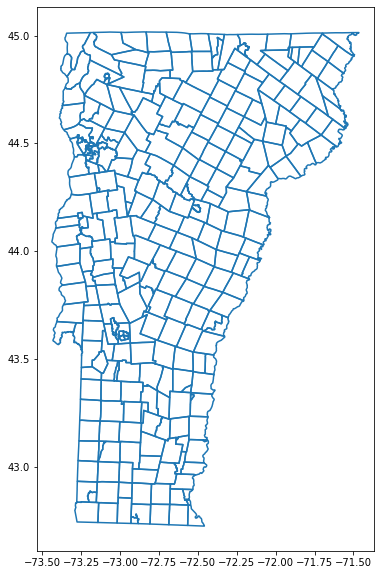

In [28]:
vest_vt_20.boundary.plot(figsize=(10,10))

### Import Census File

In [29]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Vermont"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

shp_list = []
for fips in list(fips_file["FIPS County"]):
    file_path = "./raw-from-source/Shapefiles/Census/tl_2020_50_all/tl_2020_50"+str(fips)+"_vtd20.shp"
    county_val = gp.read_file(file_path)
    shp_list.append(county_val)
full_shapefiles_census = pd.concat(shp_list, axis=0, ignore_index=True)

<AxesSubplot:>

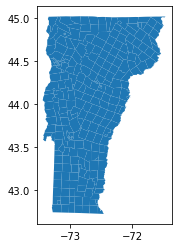

In [30]:
full_shapefiles_census.plot()

In [31]:
state_distr = gp.read_file("./raw-from-source/Shapefiles/VT_Data_-_Vermont_House_Districts_2012/VT_Data_-_Vermont_House_Districts_2012.shp")

#Grab needed columns
state_distr = state_distr[['DISTRICT','NAME','geometry']]

#Modify CRS
state_distr=state_distr.to_crs(vest_vt_20.crs)

county_sub = gp.read_file("./raw-from-source/Shapefiles/VT_2010_Census_County_Subdivision_Boundaries_and_Statistics/VT_2010_Census_County_Subdivision_Boundaries_and_Statistics.shp")

#Grab columns
county_sub = county_sub[['COUNTYFP10','NAME10', 'NAMELSAD10','geometry']]

#Modify CRS
county_sub=county_sub.to_crs(vest_vt_20.crs)

### Compare to VEST file

Aside from the handful of merges VEST mentions, these seem to match up

<AxesSubplot:>

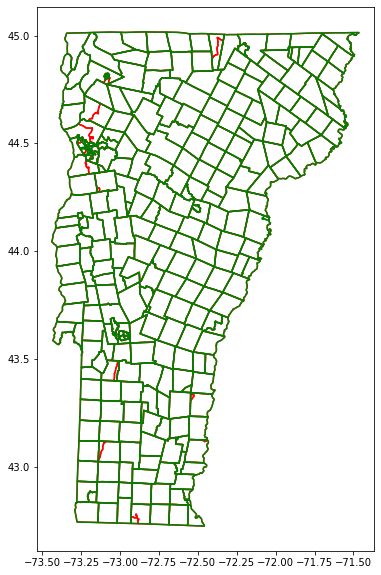

In [62]:
ax_2 = vest_vt_20.boundary.plot(figsize=(10,10),color="red")
full_shapefiles_census.boundary.plot(figsize=(10,10),ax=ax_2,color="green")

<AxesSubplot:>

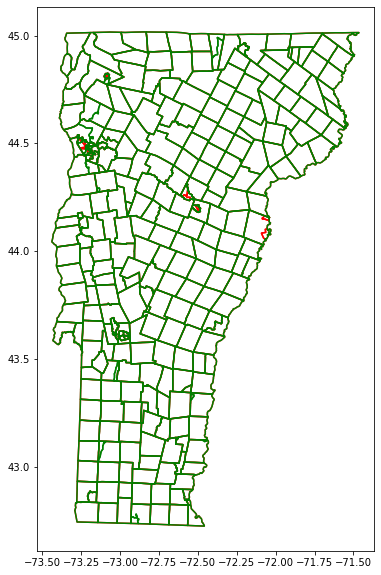

In [32]:
ax_2 = full_shapefiles_census.boundary.plot(figsize=(10,10),color="red")
vest_vt_20.boundary.plot(figsize=(10,10),ax=ax_2,color="green")

## Join Election Results to Shapefile

### Matching Names

In [33]:
full_shapefiles_census

,STATEFP20,COUNTYFP20,VTDST20,GEOID20,VTDI20,NAME20,NAMELSAD20,LSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,50,001,500101,50001500101,A,Addison,Addison Voting District,V2,G5240,N,107850893,19186009,+44.0585392,-073.3323146,"POLYGON ((-73.43771 44.04610, -73.43764 44.046..."
1,50,001,500102,50001500102,A,Bridport,Bridport Voting District,V2,G5240,N,113122218,6636563,+43.9817242,-073.3319365,"POLYGON ((-73.41251 43.98222, -73.41244 43.982..."
2,50,001,500103,50001500103,A,Bristol,Bristol Voting District,V2,G5240,N,105580399,1711997,+44.0981848,-073.0491272,"POLYGON ((-73.14963 44.17671, -73.14873 44.176..."
3,50,001,500104,50001500104,A,Cornwall,Cornwall Voting District,V2,G5240,N,74002625,422336,+43.9629183,-073.2177012,"POLYGON ((-73.25925 43.94736, -73.25925 43.947..."
4,50,001,500105,50001500105,A,Ferrisburgh,Ferrisburgh Voting District,V2,G5240,N,122958389,35539847,+44.2031331,-073.2791964,"POLYGON ((-73.40066 44.15341, -73.40029 44.154..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,50,027,502721,50027502721,A,Weathersfield,Weathersfield Voting District,V2,G5240,N,112650836,1450695,+43.3921094,-072.4767836,"POLYGON ((-72.54544 43.34529, -72.54514 43.349..."
281,50,027,502722,50027502722,A,West Windsor,West Windsor Voting District,V2,G5240,N,64175385,236018,+43.4714681,-072.5026184,"POLYGON ((-72.53283 43.53387, -72.53111 43.533..."
282,50,027,502723,50027502723,A,Weston,Weston Voting District,V2,G5240,N,91737984,509336,+43.3214411,-072.8029029,"POLYGON ((-72.86814 43.30742, -72.86809 43.308..."
283,50,027,502724,50027502724,A,Windsor,Windsor Voting District,V2,G5240,N,50392039,720453,+43.4753566,-072.4210454,"POLYGON ((-72.45487 43.43548, -72.45463 43.438..."


In [34]:
#Check number of rows and try to find a unique ID for each

print(full_shapefiles_census.shape)

print(frame.shape)
print(frame.columns)
print(len((full_shapefiles_census["NAME20"]+full_shapefiles_census["NAMELSAD20"]).unique()))
print(len((frame['NAME20']+frame['NAME20_1'].astype(str)).unique()))

#As you'll notice, there are 6 fewer election result columns

(285, 15)
(279, 51)
Index(['NAME20', 'NAME20_1', 'G20TREDPEA', 'G20TRERBRA', 'G20TREIWRI',
       'G20TREPERI', 'G20TREOWRI', 'G20ATGDDON', 'G20ATGRPAI', 'G20ATGPERI',
       'G20ATGOWRI', 'G20AUDOHOF', 'G20AUDPERI', 'G20AUDOWRI', 'G20LTGDGRA',
       'G20LTGRMIL', 'G20LTGPERI', 'G20LTGIBIL', 'G20LTGBCOR',
       'G20LTGOWRI_to_add', 'G20LTGOWRI', 'G20GOVRSCO', 'G20GOVDZUC',
       'G20GOVIHOY', 'G20GOVTPEY', 'G20GOVIWHI', 'G20GOVIBIL', 'G20GOVIDEV',
       'G20GOVUDIC', 'G20GOVOWRI', 'G20HALDWEL', 'G20HALDRBE', 'G20HALIBEC',
       'G20HALIHOR', 'G20HALCHEL', 'G20HALIORR', 'G20HALITRU', 'G20HALOWRI',
       'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW', 'G20PREIWES',
       'G20PREOOTH', 'G20PREOSAN', 'G20PREOWRI', 'G20SOSDCON', 'G20SOSRPAI',
       'G20SOSISMI', 'G20SOSPERI', 'G20SOSOWRI'],
      dtype='object')
285
279


In [35]:
full_shapefiles_census["join_col"]=full_shapefiles_census["NAME20"]+"-"+full_shapefiles_census["NAMELSAD20"]
frame["NAME20_1"]=frame["NAME20_1"].fillna("")
frame["join_col"]=frame["NAME20"]+"-"+frame["NAME20_1"].astype(str)

In [36]:
frame["join_col"].to_csv("./election_unique_ID.csv")
full_shapefiles_census["join_col"].to_csv("./shapefile_unique_ID.csv")

### Change the names to match (look through dictionary to see typical string differences)

In [37]:
state_distr[state_distr["NAME"].str[0:1]=="C"]

,DISTRICT,NAME,geometry
12,CAL-1,Caledonia-1,"MULTIPOLYGON (((-72.04330 44.15683, -72.04306 ..."
13,CAL-2,Caledonia-2,"POLYGON ((-72.37479 44.58412, -72.37455 44.584..."
14,CAL-3,Caledonia-3,"POLYGON ((-72.04549 44.39836, -72.04614 44.400..."
15,CAL-4,Caledonia-4,"POLYGON ((-72.08385 44.51040, -72.08349 44.511..."
16,CAL-WAS,Caledonia-Washington,"POLYGON ((-72.18781 44.27686, -72.18953 44.277..."
17,CHI-1,Chittenden-1,"POLYGON ((-72.91929 44.42862, -72.92154 44.418..."
18,CHI-10,Chittenden-10,"POLYGON ((-73.09733 44.57049, -73.09780 44.570..."
19,CHI-2,Chittenden-2,"POLYGON ((-73.03196 44.46804, -73.03167 44.467..."
20,CHI-3,Chittenden-3,"POLYGON ((-72.83864 44.45923, -72.83870 44.459..."
21,CHI-4-1,Chittenden-4-1,"POLYGON ((-73.19680 44.26663, -73.19874 44.266..."


In [38]:
burlington_ward_list = ["Burlington Ward 1-Burlington Ward 1",
"Burlington Ward 2-Burlington Ward 2",
"Burlington Ward 3-Burlington Ward 3",
"Burlington Ward 4-Burlington Ward 4",
"Burlington Ward 5-Burlington Ward 5",
"Burlington Ward 6-Burlington Ward 6",
"Burlington Ward 7-Burlington Ward 7",
"Burlington Ward 8-Burlington Ward 8",
"Colchester-Colchester Voting District",
"Hinesburg-Hinesburg Voting District"]

state_district_list = ["CHI-6-1","CHI-6-2","CHI-6-3","CHI-6-4","CHI-6-5","CHI-6-6","CHI-6-7",
                      "CHI-9-1","CHI-9-2","CHI-4-2"]



<AxesSubplot:>

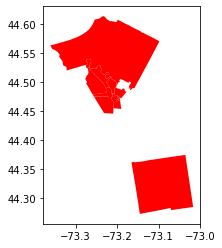

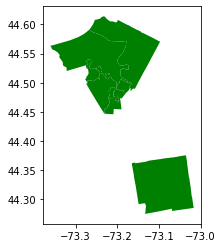

In [39]:
full_shapefiles_census[full_shapefiles_census["join_col"].isin(burlington_ward_list)].plot(color="red")
state_distr[state_distr["DISTRICT"].isin(state_district_list)].plot(color="green")

Burlington-Chittenden 6-1
Burlington-Chittenden 6-2
Burlington-Chittenden 6-3
Burlington-Chittenden 6-4
Burlington-Chittenden 6-5
Burlington-Chittenden 6-6
Burlington-Chittenden 6-7

<AxesSubplot:>

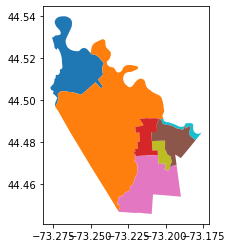

In [40]:
vest_vt_20[vest_vt_20["NAME20"].str[0:4]=="Burl"].plot(column="NAME20")

In [41]:
Colchester-Chittenden 9-1
Colchester-Chittenden 9-2

--

Colchester-Colchester Voting District

SyntaxError: invalid syntax (<ipython-input-41-a3b92400b6ae>, line 1)

In [ ]:
Hinesburg-Chittenden 4-1
Hinesburg-Chittenden 4-2

--

Hinesburg-Hinesburg Voting District

Milton-Chittenden 10
Milton-Grand Isle-Chittenden

--

Milton-Milton Voting District

--

Shelburne-Chittenden 5-1
Shelburne-Chittenden 5-2

--

Shelburne-Shelburne Voting District

Springfield-Windsor 3-1
Springfield-Windsor 3-2

--

Springfield-Springfield Voting District

--

St. Albans City-
St. Albans Town-Franklin 3-1
St. Albans Town-Franklin 3-2

--

St. Albans City Ward 1-St. Albans City Ward 1
St. Albans City Ward 2-St. Albans City Ward 2
St. Albans City Ward 3-St. Albans City Ward 3
St. Albans City Ward 4-St. Albans City Ward 4
St. Albans City Ward 5-St. Albans City Ward 5
St. Albans City Ward 6-St. Albans City Ward 6
St. Albans Town-St. Albans Town Voting District

--

Sunderland-Bennington 3
Sunderland-Bennington 4

--
Sunderland-Sunderland Voting District

--

Tinmouth-Rutland 2
Tinmouth-Rutland-Bennington

--

Tinmouth-Tinmouth Voting District

--

Troy-Orleans 2
Troy-Orleans-Lamoille

--
Troy-Troy Voting District

--

Westminster-Windham 3
Westminster-Windham 4

--

Westminster-Westminster Voting District

--

Whitingham-Windham 6
Whitingham-Windham-Bennington

--

Whittingham-Whittingham Voting District


In [42]:
name_changes_dict = {'Addison-':'Addison-Addison Voting District',
'Albany-':'Albany-Albany Voting District',
'Alburgh-':'Alburgh-Alburgh Voting District',
'Andover-':'Andover-Andover Voting District',
'Arlington-':'Artlington-Artlington Voting District',
'Athens-':'Athens-Athens Voting District',
'Averill-':'Averill-Averill Voting District',
'Bakersfield-':'Bakersfield-Bakersfield Voting District',
'Baltimore-':'Baltimore-Baltimore Voting District',
'Barnard-':'Barnard-Barnard Voting District',
'Barnet-':'Barnet-Barnet Voting District',
'Barre Town-':'Barre Town-Barre Town Voting District',
'Barton-':'Barton-Barton Voting District',
'Belvidere-':'Belvidere-Belvidere Voting District',
'Bennington-Bennington 2-1':'Bennignton District 1-Bennignton District 1',
'Bennington-Bennington 2-2':'Bennington District 2-Bennington District 2',
'Benson-':'Benson-Benson Voting District',
'Berkshire-':'Berkshire-Berkshire Voting District',
'Berlin-':'Berlin-Berlin Voting District',
'Bethel-':'Bethel-Bethel Voting District',
'Bloomfield-':'Bloomfield-Bloomfield Voting District',
'Bolton-':'Bolton-Bolton Voting District',
'Bradford-':'Bradford-Bradford Voting District',
'Braintree-':'Braintree-Braintree Voting District',
'Brandon-':'Brandon-Brandon Voting District',
'Brattleboro-Windham 2-1':'Brattleboro District 1-Brattleboro District 1',
'Brattleboro-Windham 2-2':'Brattleboro District 2-Brattleboro District 2',
'Brattleboro-Windham 2-3':'Brattleboro District 3-Brattleboro District 3',
'Bridgewater-':'Bridgewater-Bridgewater Voting District',
'Bridport-':'Bridport-Bridport Voting District',
'Brighton-':'Brighton-Brighton Voting District',
'Bristol-':'Bristol-Bristol Voting District',
'Brookfield-':'Brookfield-Brookfield Voting District',
'Brookline-':'Brookline-Brookline Voting District',
'Brownington-':'Brownington-Brownington Voting District',
'Brunswick-':'Brunswick-Brunswick Voting District',
'Buels Gore-':"Buel's Gore-Buel's Gore Voting District",
'Burke-':'Burke-Burke Voting District',
'Cabot-':'Cabot-Cabot Voting District',
'Calais-':'Calais-Calais Voting District',
'Cambridge-':'Cambridge-Cambridge Voting District',
'Canaan-':'Canaan-Canaan Voting District',
'Castleton-':'Castleton-Castleton Voting District',
'Cavendish-':'Cavendish-Cavendish Voting District',
'Charleston-':'Charleston-Charleston Voting District',
'Charlotte-':'Charlotte-Charlotte Voting District',
'Chelsea-':'Chelsea-Chelsea Voting District',
'Chester-':'Chester-Chester Voting District',
'Chittenden-':'Chittenden-Chittenden Voting District',
'Clarendon-':'Clarendon-Clarendon Voting District',
'Concord-':'Concord-Concord Voting District',
'Corinth-':'Corinth-Corinth Voting District',
'Cornwall-':'Cornwall-Cornwall Voting District',
'Coventry-':'Coventry-Coventry Voting District',
'Craftsbury-':'Craftsbury-Craftsbury Voting District',
'Danby-':'Danby-Danby Voting District',
'Danville-':'Danville-Danville Voting District',
'Derby-':'Derby-Derby Voting District',
'Dorset-':'Dorset-Dorset Voting District',
'Dover-':'Dover-Dover Voting District',
'Dummerston-':'Dummerston-Dummerston Voting District',
'Duxbury-':'Duxbury-Duxbury Voting District',
'E. Haven-':'East Haven-East Haven Voting District',
'E. Montpelier-':'East Montpelier-East Montpelier Voting District',
'Eden-':'Eden-Eden Voting District',
'Elmore-':'Elmore-Elmore Voting District',
'Enosburgh-':'Enosburgh-Enosburgh Voting District',
'Essex-Chittenden 8-1':'Essex District 1-Essex District 1',
'Essex-Chittenden 8-2':'Essex District 2-Essex District 2',
'Essex-Chittenden 8-3':'Essex District 3-Essex District 3',
'Fair Haven-':'Fair Haven-Fair Haven Voting District',
'Fairfax-':'Fairfax-Fairfax Voting District',
'Fairfield-':'Fairfield-Fairfield Voting District',
'Fairlee-':'Fairlee-Fairlee Voting District',
'Fayston-':'Fayston-Fayston Voting District',
'Ferdinand-':'Ferdinand-Ferdinand Voting District',
'Ferrisburgh-':'Ferrisburgh-Ferrisburgh Voting District',
'Fletcher-':'Fletcher-Fletcher Voting District',
'Franklin-':'Franklin-Franklin Voting District',
'Georgia-':'Georgia-Georgia Voting District',
'Glastenbury-':'Glastenbury-Glastenbury Voting District',
'Glover-':'Glover-Glover Voting District',
'Goshen-':'Goshen-Goshen Voting District',
'Grafton-':'Grafton-Grafton Voting District',
'Granby-':'Granby-Granby Voting District',
'Grand Isle-':'Grand Isle-Grand Isle Voting District',
'Granville-':'Granville-Granville Voting District',
'Greensboro-':'Greensboro-Greensboro Voting District',
'Groton-':'Groton-Groton Voting District',
'Guildhall-':'Guildhall-Guildhall Voting District',
'Guilford-':'Guilford-Guilford Voting District',
'Halifax-':'Halifax-Halifax Voting District',
'Hancock-':'Hancock-Hancock Voting District',
'Hardwick-':'Hardwick-Hardwick Voting District',
'Hartford-Windsor 4-1':'Hartford District 1-Hartford District 1',
'Hartford-Windsor 4-2':'Hartford District 2-Hartford District 2',
'Hartland-':'Hartland-Hartland Voting District',
'Highgate-':'Highgate-Highgate Voting District',
'Holland-':'Holland-Holland Voting District',
'Hubbardton-':'Hubbardton-Hubbardton Voting District',
'Huntington-':'Huntington-Huntington Voting District',
'Hyde Park-':'Hyde Park-Hyde Park Voting District',
'Ira-':'Ira-Ira Voting District',
'Irasburg-':'Irasburg-Irasburg Voting District',
'Isle La Motte-':'Isle La Motte-Isle La Motte Voting District',
'Jamaica-':'Jamacia-Jamacia Voting District',
'Jay-':'Jay-Jay Voting District',
'Jericho-':'Jericho-Jericho Voting District',
'Johnson-':'Johnson-Johnson Voting District',
'Killington-':'Killington-Killington Voting District',
'Kirby-':'Kirby-Kirby Voting District',
'Landgrove-':'Landgrove-Landgrove Voting District',
'Leicester-':'Leicester-Leicester Voting District',
'Lemington-':'Lemington-Lemington Voting District',
'Lincoln-':'Lincoln-Lincoln Voting District',
'Londonderry-':'Londonderry-Londonderry Voting District',
'Lowell-':'Lowell-Lowell Voting District',
'Ludlow-':'Ludlow-Ludlow Voting District',
'Lunenburg-':'Luneburg-Luneburg Voting District',
'Lyndon-':'Lyndon-Lyndon Voting District',
'Maidstone-':'Maidstone-Maidstone Voting District',
'Manchester-':'Manchester-Manchester Voting District',
'Marlboro-':'Marlboro-Marlboro Voting District',
'Marshfield-':'Marshfield-Marshfield Voting District',
'Mendon-':'Mendon-Mendon Voting District',
'Middlebury-':'Middlebury-Middlebury Voting District',
'Middlesex-':'Middlesex-Middlesex Voting District',
'Middletown Springs-':'Middletown Springs-Middletown Springs Voting District',
'Monkton-':'Monkton-Monkton Voting District',
'Montgomery-':'Montgomery-Montgomery Voting District',
'Moretown-':'Mooretown-Mooretown Voting District',
'Morgan-':'Morgan-Morgan Voting District',
'Morristown-':'Morristown-Morristown Voting District',
'Mount Holly-':'Mount Holly-Mount Holly Voting District',
'Mount Tabor-':'Mount Tabor-Mount Tabor Voting District',
'N. Hero-':'North Hero-North Hero Voting District',
'New Haven-':'New Haven-New Haven Voting District',
'Newark-':'Newark-Newark Voting District',
'Newfane-':'Newfane-Newfane Voting District',
'Newport City-':'Newport City-Newport City Voting District',
'Newport Town-':'Newport Town-Newport Town Voting District',
'Northfield-':'Northfield-Northfield Voting District',
'Norton-':'Norton-Norton Voting District',
'Norwich-':'Norwich-Norwich Voting District',
'Orange-':'Orange-Orange Voting District',
'Orwell-':'Orwell-Orwell Voting District',
'Panton-':'Panton-Panton Voting District',
'Pawlet-':'Pawlet-Pawlet Voting District',
'Peacham-':'Peacham-Peacham Voting District',
'Peru-':'Peru-Peru Voting District',
'Pittsfield-':'Pittsfield-Pittsfield Voting District',
'Pittsford-':'Pittsford-Pittsford Voting District',
'Plainfield-':'Plainfield-Plainfield Voting District',
'Plymouth-':'Plymouth-Plymouth Voting District',
'Pomfret-':'Pomfret-Pomfret Voting District',
'Poultney-':'Poultney-Poultney Voting District',
'Pownal-':'Pownal-Pownal Voting District',
'Proctor-':'Proctor-Proctor Voting District',
'Putney-':'Putney-Putney Voting District',
'Randolph-':'Randolph-Randolph Voting District',
'Reading-':'Reading-Reading Voting District',
'Readsboro-':'Readsboro-Readsboro Voting District',
'Richford-':'Richford-Richford Voting District',
'Richmond-':'Richmond-Richmond Voting District',
'Ripton-':'Ripton-Ripton Voting District',
'Rochester-':'Rochester-Rochester Voting District',
'Rockingham-':'Rockingham-Rockingham Voting District',
'Roxbury-':'Roxbury-Roxbury Voting District',
'Royalton-':'Royalton-Royalton Voting District',
'Rupert-':'Rupert-Rupert Voting District',
'Rutland City-Rutland 5-1':'Rutland City Ward 1-Rutland City Ward 1',
'Rutland City-Rutland 5-2':'Rutland City Ward 2-Rutland City Ward 2',
'Rutland City-Rutland 5-3':'Rutland City Ward 3-Rutland City Ward 3',
'Rutland City-Rutland 5-4':'Rutland City Ward 4-Rutland City Ward 4',
'Rutland Town-':'Rutland Town-Rutland Town Voting District',
'Ryegate-':'Ryegate-Ryegate Voting District',
'S. Burlington-Chittenden 7-1':'South Burlington District 1-South Burlington District 1',
'S. Burlington-Chittenden 7-2':'South Burlington District 2-South Burlington District 2',
'S. Burlington-Chittenden 7-3':'South Burlington District 3-South Burlington District 3',
'S. Burlington-Chittenden 7-4':'South Burlington District 4-South Burlington District 4',
'S. Hero-':'South Hero-South Hero Voting District',
'Salisbury-':'Salisbury-Salisbury Voting District',
'Sandgate-':'Sandgate-Sandgate Voting District',
'Searsburg-':'Searsburg-Searsburg Voting District',
'Shaftsbury-':'Shaftsbury-Shaftsbury Voting District',
'Sharon-':'Sharon-Sharon Voting District',
'Sheffield-':'Sheffield-Sheffield Voting District',
'Sheldon-':'Sheldon-Sheldon Voting District',
'Shoreham-':'Shoreham-Shoreham Voting District',
'Shrewsbury-':'Shrewsbury-Shrewsbury Voting District',
'St. George-':'Saint George-Saint George Voting District',
'St. Johnsbury-':'St. Johnsbury-St. Johnsbury Voting District',
'Stamford-':'Stamford-Stamford Voting District',
'Stannard-':'Stannard-Stannard Voting District',
'Starksboro-':'Starksboro-Starksboro Voting District',
'Stockbridge-':'Stockbridge-Stockbridge Voting District',
'Stowe-':'Stowe-Stowe Voting District',
'Strafford-':'Strafford-Strafford Voting District',
'Stratton-':'Stratton-Stratton Voting District',
'Sudbury-':'Sudbury-Sudbury Voting District',
'Sutton-':'Sutton-Sutton Voting District',
'Swanton-':'Swanton-Swanton Voting District',
'Thetford-':'Thetford-Thetford Voting District',
'Topsham-':'Topsham-Topsham Voting District',
'Townshend-':'Townshend-Townshend Voting District',
'Tunbridge-':'Tunbridge-Tunbridge Voting District',
'Underhill-':'Underhill-Underhill Voting District',
'Vergennes-':'Vergennes-Vergennes Voting District',
'Vernon-':'Vernon-Vernon Voting District',
'Vershire-':'Vershire-Vershire Voting District',
'Victory-':'Victory-Victory Voting District',
'W. Fairlee-':'West Fairlee-West Fairlee Voting District',
'W. Haven-':'West Haven-West Haven Voting District',
'W. Rutland-':'West Rutland-West Rutland Voting District',
'W. Windsor-':'West Windsor-West Windsor Voting District',
'Waitsfield-':'Waitsfield-Waitsfield Voting District',
'Walden-':'Walden-Walden Voting District',
'Wallingford-':'Wallingford-Wallingford Voting District',
'Waltham-':'Waltham-Waltham Voting District',
'Wardsboro-':'Wardsboro-Wardsboro Voting District',
'Warren-':'Warren-Warren Voting District',
'Washington-':'Washington-Washington Voting District',
'Waterbury-':'Waterbury-Waterbury Voting District',
'Waterford-':'Waterford-Waterford Voting District',
'Waterville-':'Waterville-Waterville Voting District',
'Weathersfield-':'Weathersfield-Weathersfield Voting District',
'Wells-':"Wells-Wells Voting District",
'Westfield-':'Westfield-Westfield Voting District',
'Westford-':'Westford-Westford Voting District',
'Westmore-':'Westmore-Westmore Voting District',
'Weston-':'Weston-Weston Voting District',
'Weybridge-':'Weybridge-Weybridge Voting District',
'Wheelock-':'Wheelock-Wheelock Voting District',
'Whiting-':'Whiting-Whiting Voting District',
'Williamstown-':'Williamstown-Williamstown Voting District',
'Williston-':'Williston-Williston Voting District',
'Wilmington-':'Wilmington-Wilmington Voting District',
'Windham-':'Windham-Windham Voting District',
'Windsor-':'Windsor-Windsor Voting District',
'Winhall-':'Winhall-Winhall Voting District',
'Winooski-':'Winooski-Winooski Voting District',
'Wolcott-':'Wolcott-Wolcott Voting District',
'Woodbury-':'Woodbury-Woodbury Voting District',
'Woodford-':'Woodford-Woodford Voting District',
'Woodstock-':'Woodstock-Woodstock Voting District',
'Worcester-':'Worcester-Worcester Voting District',}

In [43]:
def precinct_merger(precinct_list,new_precinct):
    global full_shapefiles_census
    prec_holder = []
    for i in precinct_list:
        prec_holder.append(full_shapefiles_census.loc[full_shapefiles_census["join_col"]==i])
    new_geom = pd.concat(prec_holder, ignore_index=True).unary_union
    new_prec = gp.GeoDataFrame(geometry=[new_geom],columns=["geometry","join_col"],crs = full_shapefiles_census.crs)
    new_prec["join_col"]=new_precinct
    full_shapefiles_census = full_shapefiles_census.append(new_prec)
    full_shapefiles_census = full_shapefiles_census[~full_shapefiles_census["join_col"].isin(precinct_list)]

In [44]:
precinct_merger(["Barre City Ward 1-Barre City Ward 1","Barre City Ward 2-Barre City Ward 2","Barre City Ward 3-Barre City Ward 3"],"Barre City-")
precinct_merger(["Montpelier District 1-Montpelier District 1","Montpelier District 2-Montpelier District 2","Montpelier District 3-Montpelier District 3"],"Montpelier-")
precinct_merger(["Newbury Town-Newbury Town Voting District","Newbury Village-Newbury Village Voting District"],"Newbury-")

In [45]:
frame["join_col"] = frame["join_col"].map(name_changes_dict).fillna(frame["join_col"])

### Attempt to join

In [46]:
frame["join_col"].value_counts()

Windsor-Windsor Voting District              1
Warren-Warren Voting District                1
Londonderry-Londonderry Voting District      1
Westford-Westford Voting District            1
Brunswick-Brunswick Voting District          1
                                            ..
Johnson-Johnson Voting District              1
New Haven-New Haven Voting District          1
Williamstown-Williamstown Voting District    1
Sheffield-Sheffield Voting District          1
Orwell-Orwell Voting District                1
Name: join_col, Length: 279, dtype: int64

In [47]:
source_join = pd.merge(frame,full_shapefiles_census,how="outer",on="join_col",indicator=True)
print(source_join["_merge"].value_counts())

both          249
right_only     31
left_only      30
Name: _merge, dtype: int64


In [48]:
print(source_join[source_join["_merge"]=="right_only"]["join_col"])

279              Sunderland-Sunderland Voting District
280                Burlington Ward 1-Burlington Ward 1
281                Burlington Ward 2-Burlington Ward 2
282                Burlington Ward 3-Burlington Ward 3
283                Burlington Ward 4-Burlington Ward 4
284                Burlington Ward 5-Burlington Ward 5
285                Burlington Ward 6-Burlington Ward 6
286                Burlington Ward 7-Burlington Ward 7
287                Burlington Ward 8-Burlington Ward 8
288              Colchester-Colchester Voting District
289                Hinesburg-Hinesburg Voting District
290                      Milton-Milton Voting District
291                Shelburne-Shelburne Voting District
292          Avery's Gore-Avery's Gore Voting District
293                        Lewis-Lewis Voting District
294      Warner's Grant-Warner's Grant Voting District
295        Warren's Gore-Warren's Gore Voting District
296      St. Albans City Ward 1-St. Albans City Ward 1
297      S

In [55]:
print(list(state_distr["NAME"]))

['Addison-1', 'Addison-2', 'Addison-3', 'Addison-4', 'Addison-5', 'Addison Rutland', 'Bennington-1', 'Bennington-2-1', 'Bennington-2-2', 'Bennington-3', 'Bennington-4', 'Bennington-Rutland', 'Caledonia-1', 'Caledonia-2', 'Caledonia-3', 'Caledonia-4', 'Caledonia-Washington', 'Chittenden-1', 'Chittenden-10', 'Chittenden-2', 'Chittenden-3', 'Chittenden-4-1', 'Chittenden-4-2', 'Chittenden-5-1', 'Chittenden-5-2', 'Chittenden-6-1', 'Chittenden-6-2', 'Chittenden-6-3', 'Chittenden-6-4', 'Chittenden-6-5', 'Chittenden-6-6', 'Chittenden-6-7', 'Chittenden-7-1', 'Chittenden-7-2', 'Chittenden-7-3', 'Chittenden-7-4', 'Chittenden-8-1', 'Chittenden-8-2', 'Chittenden-8-3', 'Chittenden-9-1', 'Chittenden-9-2', 'Essex-Caledonia', 'Essex-Caledonia-Orleans', 'Franklin-1', 'Franklin-2', 'Franklin-3-1', 'Franklin-3-2', 'Franklin-4', 'Franklin-5', 'Franklin-6', 'Franklin-7', 'Grand Isle-Chittenden', 'Lamoille-1', 'Lamoille-2', 'Lamoille-3', 'Lamoille-Washington', 'Orange-1', 'Orange-2', 'Orange-Caledonia', 'Ora

<AxesSubplot:>

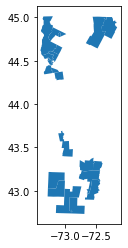

In [57]:


sub_list = ['Chittenden-6-1', 'Chittenden-6-2', 'Chittenden-6-3', 'Chittenden-6-4', 'Chittenden-6-5', 'Chittenden-6-6', 'Chittenden-6-7'
'Chittenden-4-1', 'Chittenden-4-2',
'Chittenden-9-1', 'Chittenden-9-2',
'Chittenden-10','Grand Isle-Chittenden',
'Chittenden-5-1', 'Chittenden-5-2',
'Windsor-3-1', 'Windsor-3-2',
'Franklin-3-1', 'Franklin-3-2',
'Bennington-3', 'Bennington-4',
'Rutland-2','Orleans-2','Orleans-Lamoille',
'Windham-3', 'Windham-4','Windham-6',
'Windham-Bennington']

state_distr[state_distr["NAME"].isin(sub_list)].plot()

<AxesSubplot:>

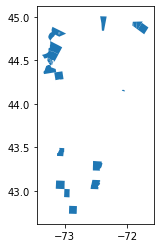

In [61]:
gp.GeoDataFrame(source_join[source_join["_merge"]=="right_only"]).plot()

In [49]:
print(source_join[source_join["_merge"]=="left_only"]["join_col"])

37         Burlington-Chittenden 6-1
38         Burlington-Chittenden 6-2
39         Burlington-Chittenden 6-3
40         Burlington-Chittenden 6-4
41         Burlington-Chittenden 6-5
42         Burlington-Chittenden 6-6
43         Burlington-Chittenden 6-7
56         Colchester-Chittenden 9-1
57         Colchester-Chittenden 9-2
104         Hinesburg-Chittenden 4-1
105         Hinesburg-Chittenden 4-2
136             Milton-Chittenden 10
137     Milton-Grand Isle-Chittenden
194         Shelburne-Chittenden 5-1
195         Shelburne-Chittenden 5-2
204          Springfield-Windsor 3-1
205          Springfield-Windsor 3-2
206                 St. Albans City-
207     St. Albans Town-Franklin 3-1
208     St. Albans Town-Franklin 3-2
219          Sunderland-Bennington 3
220          Sunderland-Bennington 4
224               Tinmouth-Rutland 2
225      Tinmouth-Rutland-Bennington
228                   Troy-Orleans 2
229            Troy-Orleans-Lamoille
254            Westminster-Windham 3
2

### Look into unjoined precincts

In [ ]:
print(source_join[source_join["_merge"]=="right_only"]["join_col"])

### Deal with no-vote precincts

Since VEST does not mention these in their documentation, nor a source for how they know when to allocate votes to precincts, we want to check whether it's reasonable to add these as no-vote precincts, without any vote allocation.

This is what VEST did, so this step is also verifying some of their work.

In [ ]:
acs_empty_precincts = pd.read_csv("./raw-from-source/ACS/Empty_Precincts/ACSST5Y2018.S0101_2021-05-24T115339/ACSST5Y2018.S0101_data_with_overlays_2021-05-24T115321.csv")

In [ ]:
acs_empty_precincts.columns = acs_empty_precincts.iloc[0]
acs_empty_precincts = acs_empty_precincts.drop([0])

#Filter to relevant columns
acs_empty_precincts = acs_empty_precincts[["Geographic Area Name","Estimate!!Total!!Total population","Margin of Error!!Total MOE!!Total population"]]

#Remove an area that was downloaded but not relevant to this analysis
acs_empty_precincts = acs_empty_precincts[acs_empty_precincts["Geographic Area Name"]!="Buels gore, Chittenden County, Vermont"]

#As you can see all of these 5 have a 0 population estimate, so it makes sense to add these as 0 pop. precincts
acs_empty_precincts

### Add the zero-vote precincts

In [ ]:
new_df = pd.DataFrame([["Avery's gore","",    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Avery's gore-ESX-CAL-ORL"],
                       ["Lewis town","", 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Lewis town-ESX-CAL-ORL"],
                       ["Warner's grant","",  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Warner's grant-ESX-CAL-ORL"],
                       ["Warren's gore","",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Warren's gore-ESX-CAL-ORL"],
                       ["Somerset town","",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Somerset town-WDH-BEN"]]
                      ,columns=frame.columns)
frame = frame.append(new_df)
frame.reset_index(inplace=True,drop=True)

### Attempt to join again

In [ ]:
source_join = pd.merge(frame,fig,how="outer",on="join_col",indicator=True)
print(source_join["_merge"].value_counts())

## Join Source File to VEST File

### Clean columns

In [ ]:
print(fig.head())

In [ ]:
print(vest_vt_20.columns)

In [ ]:
print(source_join.head())

In [ ]:
source_join = source_join[['COUNTYFP10',"NAME10","NAMELSAD10","DISTRICT","NAME",'G18USSISAN', 'G18USSRZUP', 'G18USSIPEA', 'G18USSIBES', 'G18USSIGIL',
       'G18USSIADE', 'G18USSISVI', 'G18USSIBUS', 'G18USSOKAN', 'G18USSOWRI',
       'G18HALDWEL', 'G18HALRTYN', 'G18HALIERI', 'G18HALOPOT', 'G18HALOWRI',
       'G18GOVDHAL', 'G18GOVRSCO', 'G18GOVIBAR', 'G18GOVILAR', 'G18GOVIERI',
       'G18GOVOMAR', 'G18GOVOPEY', 'G18GOVOWRI', 'G18LTGPZUC', 'G18LTGRTUR',
       'G18LTGONGO', 'G18LTGOWRI', 'G18ATGDDON', 'G18ATGRWIL', 'G18ATGOJAC',
       'G18ATGOWRI', 'G18SOSDCON', 'G18SOSRPAI', 'G18SOSOHEB', 'G18SOSOWRI',
       'G18TREDPEA', 'G18TRERMOR', 'G18TREOWRI', 'G18AUDDHOF', 'G18AUDRKEN',
       'G18AUDOBRO', 'G18AUDOWRI', 'geometry']]

### Define a unique ID for the final join

In [ ]:
source_join["final_join_col"]=source_join["NAMELSAD10"]+"-"+source_join["NAME"]+" State House District"

### Create a unique ID for VEST

In [ ]:
print(vest_vt_20.shape)
print(len((vest_vt_20["NAMELSAD"]+"-"+vest_vt_20["NAMELSAD_1"]).unique()))
vest_vt_20["final_join_col"]=vest_vt_20["NAMELSAD"]+"-"+vest_vt_20["NAMELSAD_1"]

In [ ]:
final_merge = pd.merge(vest_vt_20,source_join,how="outer",on="final_join_col",indicator="final_merge")
final_merge["final_merge"].value_counts()

### Modify Columns

In [ ]:
source_to_vest_changes_dict = {'Alburg town-Grand Isle-Chittenden State House District': 'Alburgh town-Grand-Isle-Chittenden State House District', 'Benson town-Addison Rutland State House District': 'Benson town-Addison-Rutland State House District', 'Enosburg town-Franklin-7 State House District': 'Enosburgh town-Franklin-7 State House District', 'Grand Isle town-Grand Isle-Chittenden State House District': 'Grand Isle town-Grand-Isle-Chittenden State House District', 'Isle La Motte town-Grand Isle-Chittenden State House District': 'Isle La Motte town-Grand-Isle-Chittenden State House District', 'Milton town-Grand Isle-Chittenden State House District': 'Milton town-Grand-Isle-Chittenden State House District', 'North Hero town-Grand Isle-Chittenden State House District': 'North Hero town-Grand-Isle-Chittenden State House District', 'Orwell town-Addison Rutland State House District': 'Orwell town-Addison-Rutland State House District', 'Shoreham town-Addison Rutland State House District': 'Shoreham town-Addison-Rutland State House District', 'South Hero town-Grand Isle-Chittenden State House District': 'South Hero town-Grand-Isle-Chittenden State House District', 'Whiting town-Addison Rutland State House District': 'Whiting town-Addison-Rutland State House District'}

source_join["final_join_col"] = source_join["final_join_col"].map(source_to_vest_changes_dict).fillna(source_join["final_join_col"])


In [ ]:
final_merge = pd.merge(vest_vt_20,source_join,how="outer",on="final_join_col",indicator="final_merge")
final_merge["final_merge"].value_counts()

## Validate Election Results

### County-by-county

The only difference is the one explained above with the 148 votes.

In [ ]:
diff_counties=[]
print("Counties with differences will be printed below:")
for i in data_columns:
    diff = source_join.groupby(["COUNTYFP10"]).sum()[i]-vest_vt_20.groupby(["COUNTYFP"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(diff[diff != 0].to_string(header=False))
print("")
print("All other races in all counties are equal")

### Precinct-by-precinct

In [ ]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["final_join_col"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["final_join_col"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["final_join_col"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [ ]:
validater_row(final_merge,data_columns)

The only difference is 1 vote allocated differently from how VEST does, this is likely a rounding difference.

## Validate Geometry

In [ ]:
print(final_merge.columns)

In [ ]:
both = final_merge[final_merge["final_merge"]=="both"]
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_x",crs=vest_vt_20.crs)
source_geoms = gp.GeoDataFrame(both,geometry="geometry_y",crs=vest_vt_20.crs)
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

In [ ]:
count = 0
area_list = []
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > .1):
        count += 1
        name = source_geoms.iat[i,2]
        
        print(str(count)+") For " + name + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [ ]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

### Look into Warren's Gore & Norton Town Difference

Checking to see if there was a shapefile processing error on our end, and this does not seem to be the case.

In [ ]:
ax = state_distr[state_distr["NAME"]=="Essex-Caledonia-Orleans"].plot(color="red")
limits = county_sub[county_sub["NAME10"]=="Warren's"].total_bounds
xlim = ([limits[0],limits[2]])
ylim = ([limits[1],limits[3]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
county_sub[county_sub["NAME10"]=="Warren's"].exterior.plot(ax=ax,color="blue")

In [ ]:
ax = state_distr[state_distr["NAME"]=="Essex-Caledonia-Orleans"].plot(color="red")
limits = county_sub[county_sub["NAME10"]=="Norton"].total_bounds
xlim = ([limits[0],limits[2]])
ylim = ([limits[1],limits[3]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
county_sub[county_sub["NAME10"]=="Norton"].exterior.plot(ax=ax,color="blue")